# Machine Learning - Opções Binárias

## Importações

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import pickle

## Estruturando e Visualizando os Dados

In [2]:
# transformando dataframes de USDCAD e do PETRÓLEO BRENT

h = pd.read_csv('USDCAD_Candlestick_1_Hour_BID_31.12.2009-14.04.2023.csv')
o = pd.read_csv('BRENT.CMDUSD_Candlestick_1_Hour_BID_30.11.2010-14.04.2023.csv')
# g = pd.read_csv('XAUUSD_Candlestick_1_Hour_BID_30.11.2010-14.04.2023.csv')

In [3]:
# Put USD/CAD hour data into Pandas Dataframe

df = pd.DataFrame(h)
display(df.head())
display(df.tail())

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000


,Gmt time,Open,High,Low,Close,Volume
116467,15.04.2023 19:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0
116468,15.04.2023 20:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0
116469,15.04.2023 21:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0
116470,15.04.2023 22:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0
116471,15.04.2023 23:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0


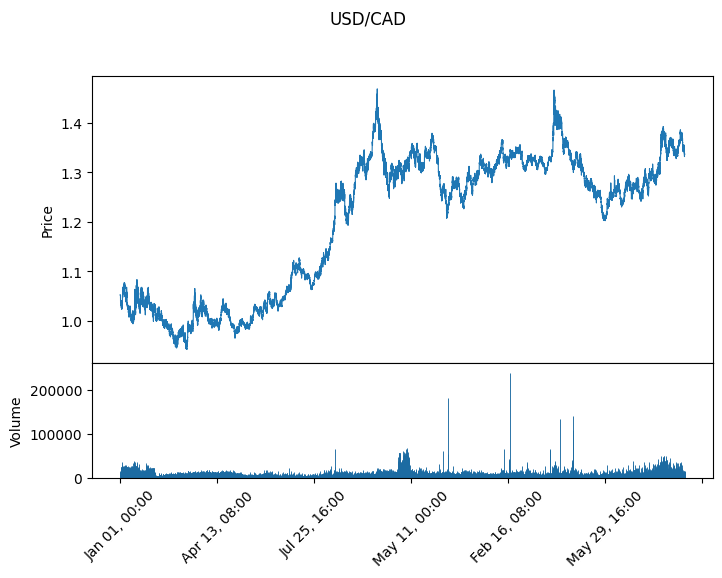

In [4]:
usd_cad = df.copy()
usd_cad.index = pd.to_datetime(usd_cad['Gmt time'])

# Renomeia as colunas para atender aos requisitos do mplfinance
usd_cad = usd_cad.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

# Define os parâmetros para o gráfico de candlestick
mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='USD/CAD', warn_too_much_data=10000000)

# Cria o gráfico de candlestick com um gráfico de barras de volume
mpf.plot(usd_cad, **kwargs)

In [5]:
# Adicionando Bandas de Bollinger
# Define o período de tempo para calcular as bandas de Bollinger
period = 20

# Calcula a média móvel simples
df['SMA'] = df['Close'].rolling(window=period).mean()

# Calcula o desvio padrão
df['STD'] = df['Close'].rolling(window=period).std()

# Calcula a banda superior
df['Upper'] = df['SMA'] + (2 * df['STD'])

# Calcula a banda inferior
df['Lower'] = df['SMA'] - (2 * df['STD'])

# Exibe o conjunto de dados com as bandas de Bollinger
display(df.head())
display(df.tail())
df.head(50)

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
116467,15.04.2023 19:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569
116468,15.04.2023 20:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569
116469,15.04.2023 21:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569
116470,15.04.2023 22:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569
116471,15.04.2023 23:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN
5,01.01.2010 05:00:00.000,1.05163,1.05168,1.05153,1.05158,4934.2998,NaN,NaN,NaN,NaN
6,01.01.2010 06:00:00.000,1.05129,1.05168,1.05129,1.05165,8427.7998,NaN,NaN,NaN,NaN
7,01.01.2010 07:00:00.000,1.05158,1.05168,1.05147,1.05160,15864.4004,NaN,NaN,NaN,NaN
8,01.01.2010 08:00:00.000,1.05158,1.05168,1.05142,1.05165,13270.4004,NaN,NaN,NaN,NaN
9,01.01.2010 09:00:00.000,1.05165,1.05168,1.05147,1.05158,12310.0000,NaN,NaN,NaN,NaN


In [6]:
# Adicionar Stocharstico
# Define o período de tempo para calcular o indicador estocástico
period = 14

# Calcula o preço mínimo dos últimos 14 dias
low_min = df['Low'].rolling(window=period).min()

# Calcula o preço máximo dos últimos 14 dias
high_max = df['High'].rolling(window=period).max()

# Calcula a diferença entre o preço de fechamento atual e o preço mínimo do período
close_diff = df['Close'] - low_min

# Calcula a diferença entre o preço máximo e mínimo do período
high_diff = high_max - low_min

# Calcula a porcentagem da diferença entre o preço atual e o preço mínimo em relação à diferença entre o preço máximo e mínimo do período
stoch = close_diff / high_diff * 100

# Adiciona o resultado como uma nova coluna ao conjunto de dados
df['Stochastic'] = stoch

# Exibe o conjunto de dados com o indicador estocástico
display(df.head())
display(df.tail())
df.head(50)

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN,NaN
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN,NaN
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN,NaN
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN,NaN
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic
116467,15.04.2023 19:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN
116468,15.04.2023 20:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN
116469,15.04.2023 21:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN
116470,15.04.2023 22:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN
116471,15.04.2023 23:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN,NaN
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN,NaN
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN,NaN
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN,NaN
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN,NaN
5,01.01.2010 05:00:00.000,1.05163,1.05168,1.05153,1.05158,4934.2998,NaN,NaN,NaN,NaN,NaN
6,01.01.2010 06:00:00.000,1.05129,1.05168,1.05129,1.05165,8427.7998,NaN,NaN,NaN,NaN,NaN
7,01.01.2010 07:00:00.000,1.05158,1.05168,1.05147,1.05160,15864.4004,NaN,NaN,NaN,NaN,NaN
8,01.01.2010 08:00:00.000,1.05158,1.05168,1.05142,1.05165,13270.4004,NaN,NaN,NaN,NaN,NaN
9,01.01.2010 09:00:00.000,1.05165,1.05168,1.05147,1.05158,12310.0000,NaN,NaN,NaN,NaN,NaN


In [7]:
# Calculado RSI
# Define o período de tempo para calcular o RSI
period = 14

# Calcula as diferenças entre o preço de fechamento atual e o preço de fechamento do dia anterior
diff = df['Close'].diff()

# Separa as diferenças em ganhos e perdas
gain = diff.where(diff > 0, 0)
loss = -diff.where(diff < 0, 0)

# Calcula a média móvel exponencial dos ganhos e perdas
ema_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
ema_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

# Calcula a relação entre a média móvel dos ganhos e perdas, obtendo o RSI
rs = ema_gain / ema_loss
rsi = 100 - (100 / (1 + rs))

# Adiciona o resultado como uma nova coluna ao conjunto de dados
df['RSI'] = rsi

# Exibe o conjunto de dados com o RSI
display(df.head())
display(df.tail())


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI
0,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN,NaN,NaN
1,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN,NaN,NaN
2,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN,NaN,NaN
3,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN,NaN,NaN
4,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI
116467,15.04.2023 19:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN,51.096089
116468,15.04.2023 20:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN,51.096089
116469,15.04.2023 21:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN,51.096089
116470,15.04.2023 22:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN,51.096089
116471,15.04.2023 23:00:00.000,1.33569,1.33569,1.33569,1.33569,0.0,1.33569,0.0,1.33569,1.33569,NaN,51.096089


In [8]:
# Dados do petróleo brent

df_oil = pd.DataFrame(o)
display(df_oil.head())
display(df_oil.tail())

,Gmt time,Open,High,Low,Close,Volume
0,01.12.2010 00:00:00.000,88.734,88.734,88.734,88.734,0.0
1,01.12.2010 01:00:00.000,88.734,88.734,88.734,88.734,0.0
2,01.12.2010 02:00:00.000,88.734,88.734,88.734,88.734,0.0
3,01.12.2010 03:00:00.000,88.734,88.734,88.734,88.734,0.0
4,01.12.2010 04:00:00.000,88.734,88.734,88.734,88.734,0.0


,Gmt time,Open,High,Low,Close,Volume
108451,15.04.2023 19:00:00.000,86.442,86.442,86.442,86.442,0.0
108452,15.04.2023 20:00:00.000,86.442,86.442,86.442,86.442,0.0
108453,15.04.2023 21:00:00.000,86.442,86.442,86.442,86.442,0.0
108454,15.04.2023 22:00:00.000,86.442,86.442,86.442,86.442,0.0
108455,15.04.2023 23:00:00.000,86.442,86.442,86.442,86.442,0.0


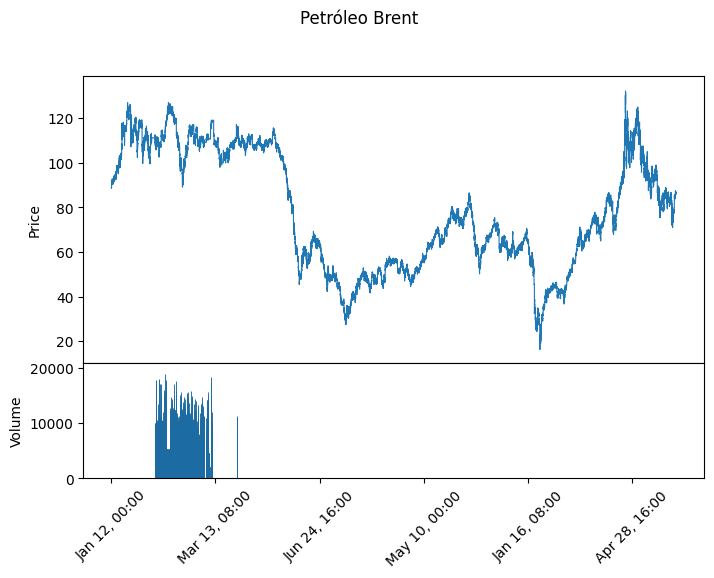

In [9]:
oil = df_oil.copy()
oil.index = pd.to_datetime(oil['Gmt time'])

# Renomeia as colunas para atender aos requisitos do mplfinance
oil = oil.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

# Define os parâmetros para o gráfico de candlestick
mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='Petróleo Brent',warn_too_much_data=10000000)

# Cria o gráfico de candlestick com um gráfico de barras de volume
mpf.plot(oil, **kwargs)

In [10]:
# # Dados do Ouro
# df_gold = pd.DataFrame(g)
# display(df_gold.head())
# display(df_gold.tail())

In [11]:
# Colocando a data como index
df['datetime'] = pd.to_datetime(df['Gmt time'])
df = df.set_index(df['datetime'])
df.index.names = [None]
df = df.drop(df[df['Volume'] == 0].index)
df

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime
2010-01-01 00:00:00,01.01.2010 00:00:00.000,1.05150,1.05165,1.05143,1.05160,1573.2000,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:00:00
2010-01-01 01:00:00,01.01.2010 01:00:00.000,1.05150,1.05160,1.05127,1.05135,887.5000,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 01:00:00
2010-01-01 02:00:00,01.01.2010 02:00:00.000,1.05138,1.05168,1.05133,1.05155,5087.6001,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 02:00:00
2010-01-01 03:00:00,01.01.2010 03:00:00.000,1.05153,1.05167,1.05150,1.05158,5813.2002,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 03:00:00
2010-01-01 04:00:00,01.01.2010 04:00:00.000,1.05158,1.05167,1.05146,1.05163,6501.5000,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 16:00:00,14.04.2023 16:00:00.000,1.33781,1.33954,1.33748,1.33868,7234.9800,1.333437,0.001991,1.337418,1.329456,90.975866,65.716611,2023-04-14 16:00:00
2023-04-14 17:00:00,14.04.2023 17:00:00.000,1.33867,1.33880,1.33735,1.33782,6113.5500,1.333639,0.002219,1.338077,1.329201,81.951731,61.106634,2023-04-14 17:00:00
2023-04-14 18:00:00,14.04.2023 18:00:00.000,1.33782,1.33782,1.33582,1.33593,4366.3800,1.333732,0.002276,1.338285,1.329180,62.119622,52.405970,2023-04-14 18:00:00
2023-04-14 19:00:00,14.04.2023 19:00:00.000,1.33595,1.33709,1.33593,1.33641,3745.5500,1.333852,0.002354,1.338559,1.329145,67.156348,54.189946,2023-04-14 19:00:00


In [12]:
# Set datetime for oil

df_oil['datetime'] = pd.to_datetime(df_oil['Gmt time'])
df_oil = df_oil.set_index(df_oil['datetime'])
df_oil.index.names = [None]
df_oil

,Gmt time,Open,High,Low,Close,Volume,datetime
2010-01-12 00:00:00,01.12.2010 00:00:00.000,88.734,88.734,88.734,88.734,0.0,2010-01-12 00:00:00
2010-01-12 01:00:00,01.12.2010 01:00:00.000,88.734,88.734,88.734,88.734,0.0,2010-01-12 01:00:00
2010-01-12 02:00:00,01.12.2010 02:00:00.000,88.734,88.734,88.734,88.734,0.0,2010-01-12 02:00:00
2010-01-12 03:00:00,01.12.2010 03:00:00.000,88.734,88.734,88.734,88.734,0.0,2010-01-12 03:00:00
2010-01-12 04:00:00,01.12.2010 04:00:00.000,88.734,88.734,88.734,88.734,0.0,2010-01-12 04:00:00
...,...,...,...,...,...,...,...
2023-04-15 19:00:00,15.04.2023 19:00:00.000,86.442,86.442,86.442,86.442,0.0,2023-04-15 19:00:00
2023-04-15 20:00:00,15.04.2023 20:00:00.000,86.442,86.442,86.442,86.442,0.0,2023-04-15 20:00:00
2023-04-15 21:00:00,15.04.2023 21:00:00.000,86.442,86.442,86.442,86.442,0.0,2023-04-15 21:00:00
2023-04-15 22:00:00,15.04.2023 22:00:00.000,86.442,86.442,86.442,86.442,0.0,2023-04-15 22:00:00


In [13]:
# # Set datetime for gold

# df_gold['datetime'] = pd.to_datetime(df_gold['Gmt time'])
# df_gold = df_gold.set_index(df_gold['datetime'])
# df_gold.index.names = [None]
# df_gold

In [14]:
df_oil = df_oil.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]

df_oil = df_oil.rename(columns={'Open': 'Open_oil', 'High': 'High_oil', 'Low':'Low_oil', 'Close':'Close_oil', 'Volume':'Volume_oil'})
df_oil = df_oil.drop(df_oil[df_oil['Volume_oil'] == 0].index)
df_oil.tail()

,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2023-04-14 16:00:00,86.433,86.523,85.978,86.408,0.2491
2023-04-14 17:00:00,86.418,86.623,86.223,86.323,0.2602
2023-04-14 18:00:00,86.328,86.373,86.028,86.248,0.2412
2023-04-14 19:00:00,86.253,86.463,86.208,86.418,0.0965
2023-04-14 20:00:00,86.412,86.472,86.382,86.442,0.0061


In [15]:
# df_gold = df_gold.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]

# df_gold = df_gold.rename(columns={'Open': 'Open_gold', 'High': 'High_gold', 'Low':'Low_gold', 'Close':'Close_gold', 'Volume':'Volume_gold'})
# df_gold = df_gold.drop(df_gold[df_gold['Volume_gold'] == 0].index)
# df_gold.tail()

<Axes: >

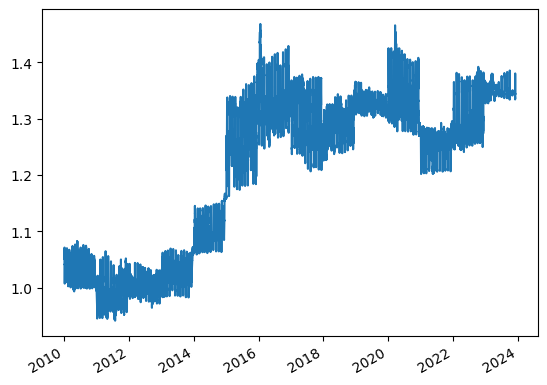

In [16]:
# Just some exploration 

df['Close'].plot()

<Axes: >

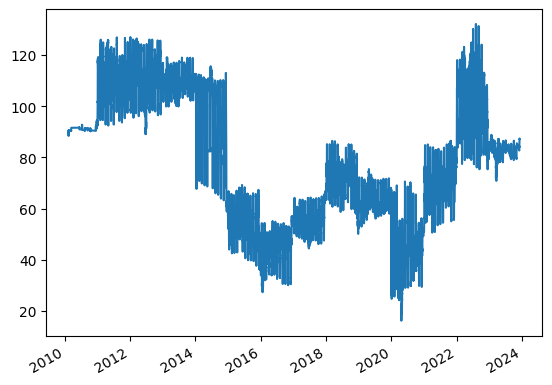

In [17]:
df_oil['Close_oil'].plot()

In [18]:
# df_gold['Close_gold'].plot()

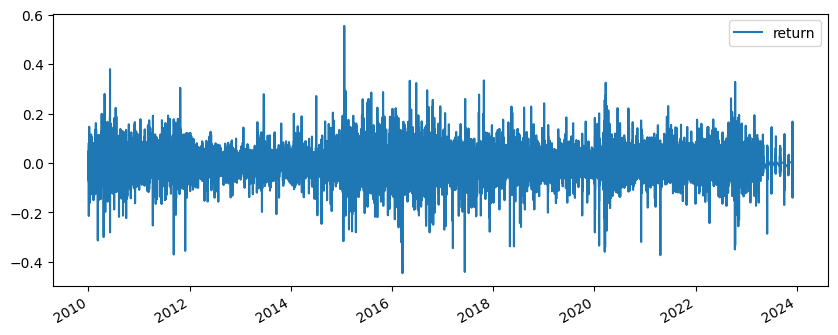

-0.44550238035580253

In [19]:
# Create return (close-open) normalized

df['return_next'] = df['Close'].shift(-1) - df['Open'].shift(-1)
return_range = df['return_next'].max() - df['return_next'].min()
df['return_next'] = df['return_next'] / return_range

df['return'] = df['Close'] - df['Open']
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(y='return', figsize=(10,4))

plt.show()

df['return'].min()

In [20]:
# Make label, 1 as rising price, 0 as falling price - prediction for the following timestamp
# ****************** consider when return ==0 next version

df['label'] = df['return_next'].apply(lambda x: 1 if x>0 else 0)
df.tail(10)

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime,return_next,return,label
2023-04-14 11:00:00,14.04.2023 11:00:00.000,1.33165,1.33342,1.33164,1.33234,4413.30,1.332912,0.000896,1.334704,1.331121,32.659933,32.489122,2023-04-14 11:00:00,0.039589,0.017289,1
2023-04-14 12:00:00,14.04.2023 12:00:00.000,1.33235,1.33493,1.33001,1.33393,13324.42,1.332888,0.000858,1.334605,1.331171,79.674797,45.674691,2023-04-14 12:00:00,-0.029567,0.039589,0
2023-04-14 13:00:00,14.04.2023 13:00:00.000,1.33396,1.33480,1.33242,1.33278,10105.35,1.332828,0.000819,1.334466,1.331190,56.300813,39.643748,2023-04-14 13:00:00,0.088700,-0.029567,1
2023-04-14 14:00:00,14.04.2023 14:00:00.000,1.33281,1.33710,1.33278,1.33635,16370.88,1.332974,0.001132,1.335239,1.330709,89.421721,58.127601,2023-04-14 14:00:00,0.036833,0.088700,1
2023-04-14 15:00:00,14.04.2023 15:00:00.000,1.33635,1.33812,1.33610,1.33782,9843.56,1.333183,0.001565,1.336313,1.330053,96.300863,63.134047,2023-04-14 15:00:00,0.021799,0.036833,1
2023-04-14 16:00:00,14.04.2023 16:00:00.000,1.33781,1.33954,1.33748,1.33868,7234.98,1.333437,0.001991,1.337418,1.329456,90.975866,65.716611,2023-04-14 16:00:00,-0.021298,0.021799,0
2023-04-14 17:00:00,14.04.2023 17:00:00.000,1.33867,1.33880,1.33735,1.33782,6113.55,1.333639,0.002219,1.338077,1.329201,81.951731,61.106634,2023-04-14 17:00:00,-0.047357,-0.021298,0
2023-04-14 18:00:00,14.04.2023 18:00:00.000,1.33782,1.33782,1.33582,1.33593,4366.38,1.333732,0.002276,1.338285,1.329180,62.119622,52.405970,2023-04-14 18:00:00,0.011526,-0.047357,1
2023-04-14 19:00:00,14.04.2023 19:00:00.000,1.33595,1.33709,1.33593,1.33641,3745.55,1.333852,0.002354,1.338559,1.329145,67.156348,54.189946,2023-04-14 19:00:00,-0.018041,0.011526,0
2023-04-14 20:00:00,14.04.2023 20:00:00.000,1.33641,1.33667,1.33558,1.33569,2264.61,1.333970,0.002385,1.338740,1.329199,59.601259,51.096089,2023-04-14 20:00:00,NaN,-0.018041,0


In [21]:
# The last register shows a NaN

df.dropna(inplace=True)

df.tail()

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,Stochastic,RSI,datetime,return_next,return,label
2023-04-14 15:00:00,14.04.2023 15:00:00.000,1.33635,1.33812,1.33610,1.33782,9843.56,1.333183,0.001565,1.336313,1.330053,96.300863,63.134047,2023-04-14 15:00:00,0.021799,0.036833,1
2023-04-14 16:00:00,14.04.2023 16:00:00.000,1.33781,1.33954,1.33748,1.33868,7234.98,1.333437,0.001991,1.337418,1.329456,90.975866,65.716611,2023-04-14 16:00:00,-0.021298,0.021799,0
2023-04-14 17:00:00,14.04.2023 17:00:00.000,1.33867,1.33880,1.33735,1.33782,6113.55,1.333639,0.002219,1.338077,1.329201,81.951731,61.106634,2023-04-14 17:00:00,-0.047357,-0.021298,0
2023-04-14 18:00:00,14.04.2023 18:00:00.000,1.33782,1.33782,1.33582,1.33593,4366.38,1.333732,0.002276,1.338285,1.329180,62.119622,52.405970,2023-04-14 18:00:00,0.011526,-0.047357,1
2023-04-14 19:00:00,14.04.2023 19:00:00.000,1.33595,1.33709,1.33593,1.33641,3745.55,1.333852,0.002354,1.338559,1.329145,67.156348,54.189946,2023-04-14 19:00:00,-0.018041,0.011526,0


In [22]:
df2 = df.copy()

df = df.loc[:,['Open', 'High', 'Low', 'Close', 'Volume','SMA','Upper','Lower','Stochastic', 'RSI', 'return', 'label']]
df.tail()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,return,label
2023-04-14 15:00:00,1.33635,1.33812,1.33610,1.33782,9843.56,1.333183,1.336313,1.330053,96.300863,63.134047,0.036833,1
2023-04-14 16:00:00,1.33781,1.33954,1.33748,1.33868,7234.98,1.333437,1.337418,1.329456,90.975866,65.716611,0.021799,0
2023-04-14 17:00:00,1.33867,1.33880,1.33735,1.33782,6113.55,1.333639,1.338077,1.329201,81.951731,61.106634,-0.021298,0
2023-04-14 18:00:00,1.33782,1.33782,1.33582,1.33593,4366.38,1.333732,1.338285,1.329180,62.119622,52.405970,-0.047357,1
2023-04-14 19:00:00,1.33595,1.33709,1.33593,1.33641,3745.55,1.333852,1.338559,1.329145,67.156348,54.189946,0.011526,0


In [23]:
df = pd.concat([df,df_oil],axis=1, join='inner')
df.head()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2010-02-12 01:00:00,1.01727,1.01796,1.01702,1.01762,2814.1001,1.018588,1.023132,1.014044,46.737683,42.004132,0.008770,1,88.734,88.734,88.39,88.61,0.2318
2010-02-12 02:00:00,1.01763,1.01837,1.01746,1.01831,1860.2000,1.018359,1.022424,1.014293,55.925433,45.534296,0.017038,0,88.600,88.690,88.54,88.68,0.1199
2010-02-12 03:00:00,1.01831,1.01838,1.01707,1.01747,1960.6000,1.018158,1.021960,1.014355,44.740346,42.169124,-0.021047,0,88.690,88.760,88.54,88.54,0.1275
2010-02-12 04:00:00,1.01747,1.01859,1.01730,1.01747,1821.6000,1.017949,1.021387,1.014511,44.740346,42.169124,0.000000,0,88.550,88.800,88.49,88.73,0.2463
2010-02-12 05:00:00,1.01747,1.01747,1.01597,1.01616,1730.1000,1.017654,1.020585,1.014724,31.733746,37.197041,-0.032824,0,88.740,88.810,88.61,88.64,0.1913


In [24]:
# df = pd.concat([df,df_gold],axis=1, join='inner')
# df.head()

In [25]:
df.tail()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2023-04-14 15:00:00,1.33635,1.33812,1.33610,1.33782,9843.56,1.333183,1.336313,1.330053,96.300863,63.134047,0.036833,1,85.933,86.557,85.773,86.428,0.3805
2023-04-14 16:00:00,1.33781,1.33954,1.33748,1.33868,7234.98,1.333437,1.337418,1.329456,90.975866,65.716611,0.021799,0,86.433,86.523,85.978,86.408,0.2491
2023-04-14 17:00:00,1.33867,1.33880,1.33735,1.33782,6113.55,1.333639,1.338077,1.329201,81.951731,61.106634,-0.021298,0,86.418,86.623,86.223,86.323,0.2602
2023-04-14 18:00:00,1.33782,1.33782,1.33582,1.33593,4366.38,1.333732,1.338285,1.329180,62.119622,52.405970,-0.047357,1,86.328,86.373,86.028,86.248,0.2412
2023-04-14 19:00:00,1.33595,1.33709,1.33593,1.33641,3745.55,1.333852,1.338559,1.329145,67.156348,54.189946,0.011526,0,86.253,86.463,86.208,86.418,0.0965


In [26]:
# Criando o datetime das features


df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

df['hour'] = df.index.hour


df.head()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2010-02-12 01:00:00,1.01727,1.01796,1.01702,1.01762,2814.1001,1.018588,1.023132,1.014044,46.737683,42.004132,...,1,88.734,88.734,88.39,88.61,0.2318,2010,2,12,1
2010-02-12 02:00:00,1.01763,1.01837,1.01746,1.01831,1860.2000,1.018359,1.022424,1.014293,55.925433,45.534296,...,0,88.600,88.690,88.54,88.68,0.1199,2010,2,12,2
2010-02-12 03:00:00,1.01831,1.01838,1.01707,1.01747,1960.6000,1.018158,1.021960,1.014355,44.740346,42.169124,...,0,88.690,88.760,88.54,88.54,0.1275,2010,2,12,3
2010-02-12 04:00:00,1.01747,1.01859,1.01730,1.01747,1821.6000,1.017949,1.021387,1.014511,44.740346,42.169124,...,0,88.550,88.800,88.49,88.73,0.2463,2010,2,12,4
2010-02-12 05:00:00,1.01747,1.01747,1.01597,1.01616,1730.1000,1.017654,1.020585,1.014724,31.733746,37.197041,...,0,88.740,88.810,88.61,88.64,0.1913,2010,2,12,5


In [27]:
df.dtypes

# we have to change the volume type later

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
SMA           float64
Upper         float64
Lower         float64
Stochastic    float64
RSI           float64
return        float64
label           int64
Open_oil      float64
High_oil      float64
Low_oil       float64
Close_oil     float64
Volume_oil    float64
year            int64
month           int64
day             int64
hour            int64
dtype: object

## Escolhendo um DataFrame para o Trade

In [28]:
# Limiting the dataframe: from 3:00 to 12:00 (10 timestamps) 

# df = df.between_time(include_start=True,include_end=True, start_time='03:00:00', end_time='12:00:00')
# df = df.drop(df[df['Volume'] == 0].index)
df.tail(20)

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2023-04-14 00:00:00,1.33403,1.33434,1.33266,1.33334,3445.59,1.336901,1.343645,1.330156,8.468244,21.413840,...,0,86.165,86.293,86.038,86.188,0.0645,2023,4,14,0
2023-04-14 01:00:00,1.33334,1.33341,1.33211,1.33214,3123.11,1.336330,1.342621,1.330039,0.349650,18.532484,...,1,86.178,86.463,86.178,86.447,0.1510,2023,4,14,1
2023-04-14 02:00:00,1.33214,1.33258,1.33167,1.33234,3282.40,1.335857,1.341829,1.329884,8.758170,20.453612,...,0,86.442,86.532,86.207,86.292,0.1056,2023,4,14,2
2023-04-14 03:00:00,1.33234,1.33260,1.33177,1.33227,1470.20,1.335438,1.341169,1.329708,9.868421,20.273413,...,1,86.282,86.452,86.197,86.418,0.0616,2023,4,14,3
2023-04-14 04:00:00,1.33226,1.33259,1.33198,1.33229,1404.19,1.335028,1.340397,1.329659,10.580205,20.488952,...,0,86.413,86.458,86.348,86.368,0.0201,2023,4,14,4
2023-04-14 05:00:00,1.33226,1.33289,1.33213,1.33216,1942.68,1.334654,1.339703,1.329605,13.535912,20.108414,...,1,86.378,86.473,86.303,86.428,0.0519,2023,4,14,5
2023-04-14 06:00:00,1.33213,1.33267,1.33166,1.33231,4229.31,1.334316,1.339013,1.329619,21.103896,21.910614,...,0,86.423,86.423,86.193,86.218,0.0896,2023,4,14,6
2023-04-14 07:00:00,1.33233,1.33339,1.33205,1.33221,4578.52,1.333921,1.337829,1.330013,19.927536,21.561415,...,1,86.228,86.268,85.693,85.723,0.1557,2023,4,14,7
2023-04-14 08:00:00,1.33220,1.33321,1.33203,1.33277,5005.68,1.333603,1.336671,1.330535,41.417910,28.439451,...,0,85.728,86.133,85.603,86.003,0.2150,2023,4,14,8
2023-04-14 09:00:00,1.33278,1.33306,1.33145,1.33149,3985.17,1.333307,1.335940,1.330674,1.384083,23.390695,...,1,85.998,86.388,85.933,86.378,0.1118,2023,4,14,9


In [29]:
# Make training and test dataset

df_test = df.loc['2023-01-01':,:]  
display(df_test.head())
display(df_test.tail())

df_train = df.loc[:'2022-12-31',:] 
display(df_train.head())
display(df_train.tail())

C:\Users\arthu\AppData\Local\Temp\ipykernel_22312\4166660910.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_test = df.loc['2023-01-01':,:]


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2023-03-01 01:00:00,1.35735,1.36184,1.35735,1.36099,9234.9199,1.356488,1.359748,1.353228,87.218045,76.380572,...,0,85.744,85.892,84.842,85.087,0.2655,2023,3,1,1
2023-03-01 02:00:00,1.36097,1.36187,1.35749,1.35752,8710.5996,1.356676,1.359699,1.353653,34.880240,54.953535,...,0,85.092,85.527,84.857,85.512,0.1574,2023,3,1,2
2023-03-01 03:00:00,1.35751,1.35751,1.35407,1.35422,5576.7202,1.356747,1.359435,1.354059,1.923077,42.688709,...,1,85.522,85.707,85.357,85.627,0.0826,2023,3,1,3
2023-03-01 04:00:00,1.35419,1.35538,1.35411,1.35533,2741.7600,1.356794,1.359337,1.354251,16.153846,46.975534,...,1,85.632,85.632,85.467,85.477,0.0311,2023,3,1,4
2023-03-01 05:00:00,1.35533,1.35703,1.35498,1.35613,3942.2500,1.356807,1.359332,1.354283,26.410256,49.885011,...,0,85.472,86.007,85.367,85.987,0.0555,2023,3,1,5


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2023-04-14 15:00:00,1.33635,1.33812,1.33610,1.33782,9843.56,1.333183,1.336313,1.330053,96.300863,63.134047,...,1,85.933,86.557,85.773,86.428,0.3805,2023,4,14,15
2023-04-14 16:00:00,1.33781,1.33954,1.33748,1.33868,7234.98,1.333437,1.337418,1.329456,90.975866,65.716611,...,0,86.433,86.523,85.978,86.408,0.2491,2023,4,14,16
2023-04-14 17:00:00,1.33867,1.33880,1.33735,1.33782,6113.55,1.333639,1.338077,1.329201,81.951731,61.106634,...,0,86.418,86.623,86.223,86.323,0.2602,2023,4,14,17
2023-04-14 18:00:00,1.33782,1.33782,1.33582,1.33593,4366.38,1.333732,1.338285,1.329180,62.119622,52.405970,...,1,86.328,86.373,86.028,86.248,0.2412,2023,4,14,18
2023-04-14 19:00:00,1.33595,1.33709,1.33593,1.33641,3745.55,1.333852,1.338559,1.329145,67.156348,54.189946,...,0,86.253,86.463,86.208,86.418,0.0965,2023,4,14,19


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2010-02-12 01:00:00,1.01727,1.01796,1.01702,1.01762,2814.1001,1.018588,1.023132,1.014044,46.737683,42.004132,...,1,88.734,88.734,88.39,88.61,0.2318,2010,2,12,1
2010-02-12 02:00:00,1.01763,1.01837,1.01746,1.01831,1860.2000,1.018359,1.022424,1.014293,55.925433,45.534296,...,0,88.600,88.690,88.54,88.68,0.1199,2010,2,12,2
2010-02-12 03:00:00,1.01831,1.01838,1.01707,1.01747,1960.6000,1.018158,1.021960,1.014355,44.740346,42.169124,...,0,88.690,88.760,88.54,88.54,0.1275,2010,2,12,3
2010-02-12 04:00:00,1.01747,1.01859,1.01730,1.01747,1821.6000,1.017949,1.021387,1.014511,44.740346,42.169124,...,0,88.550,88.800,88.49,88.73,0.2463,2010,2,12,4
2010-02-12 05:00:00,1.01747,1.01747,1.01597,1.01616,1730.1000,1.017654,1.020585,1.014724,31.733746,37.197041,...,0,88.740,88.810,88.61,88.64,0.1913,2010,2,12,5


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Stochastic,RSI,...,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2022-12-30 15:00:00,1.35418,1.35813,1.35399,1.35483,21577.0996,1.354490,1.356116,1.352863,51.470588,49.672756,...,0,84.572,84.657,83.892,84.062,0.2989,2022,12,30,15
2022-12-30 16:00:00,1.35485,1.35489,1.35275,1.35315,10939.1396,1.354435,1.356166,1.352705,26.764706,42.372062,...,0,84.047,84.367,83.939,84.237,0.2278,2022,12,30,16
2022-12-30 17:00:00,1.35314,1.35438,1.35264,1.35295,7858.3799,1.354349,1.356197,1.352501,23.823529,41.588409,...,1,84.242,84.607,84.234,84.507,0.1962,2022,12,30,17
2022-12-30 18:00:00,1.35294,1.35534,1.35276,1.35529,15335.4297,1.354378,1.356268,1.352488,58.235294,52.627656,...,0,84.512,84.732,84.132,84.717,0.2278,2022,12,30,18
2022-12-30 19:00:00,1.35524,1.35676,1.35327,1.35337,10036.8496,1.354276,1.356151,1.352401,30.000000,45.096624,...,1,84.727,85.972,84.627,85.942,0.3771,2022,12,30,19


In [30]:
df_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower',
       'Stochastic', 'RSI', 'return', 'label', 'Open_oil', 'High_oil',
       'Low_oil', 'Close_oil', 'Volume_oil', 'year', 'month', 'day', 'hour'],
      dtype='object')

## Treinando o Modelo

In [31]:
# Separate features and output

y_train = df_train['label']
X_train = df_train.loc[:,['Open', 'High', 'Low', 'Close', 'Volume','SMA', 'Upper','Lower','Stochastic','RSI', 'return', 'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Volume_oil',
       'year', 'month', 'day', 'hour']]

y_test = df_test['label']
X_test = df_test.loc[:,['Open', 'High', 'Low', 'Close', 'Volume','SMA','Upper','Lower','Stochastic','RSI', 'return', 'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Volume_oil',
       'year', 'month', 'day', 'hour']]


In [32]:
print(X_test.shape)
print(y_test.shape)

print('%% of Class0 : %f y_test' % (np.count_nonzero(y_test == 0)/float(len(y_test))))
print('%% of Class1 : %f y_test' % (np.count_nonzero(y_test == 1)/float(len(y_test))))

(1532, 20)
(1532,)
% of Class0 : 0.501958 y_test
% of Class1 : 0.498042 y_test


In [33]:
print(X_train.shape)
print(y_train.shape)

print('%% of Class0 : %f y_train' % (np.count_nonzero(y_train == 0)/float(len(y_train))))
print('%% of Class1 : %f y_train' % (np.count_nonzero(y_train == 1)/float(len(y_train))))

(63391, 20)
(63391,)
% of Class0 : 0.505466 y_train
% of Class1 : 0.494534 y_train


In [ ]:
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000, verbose=3)

scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3861           54.49m
         2           1.3860           53.74m
         3           1.3859           53.93m
         4           1.3858           53.81m
         5           1.3857           53.74m
         6           1.3857           53.66m
         7           1.3856           53.68m
         8           1.3855           53.81m
         9           1.3854           53.86m
        10           1.3854           53.83m
        11           1.3853           53.77m
        12           1.3852           53.82m
        13           1.3851           53.83m
        14           1.3851           53.79m
        15           1.3850           53.80m
        16           1.3849           53.79m
        17           1.3849           53.84m
        18           1.3848           53.77m
        19           1.3847           53.72m
        20           1.3847           53.63m
        21           1.3846           53.60m
        2

## Testando o Model

In [ ]:
accuracy = clf.score(X_train, y_train)
print('Testing Accuracy: %f' % accuracy)

In [ ]:
# Predict test data

pred = clf.predict(X_test)

In [ ]:
# Comparing predicted and label

df_trade = pd.DataFrame(X_test)
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']

df_trade

In [ ]:
# Didnt won and won

print(df_trade[df_trade['won'] == False]['won'].count())
print(df_trade[df_trade['won'] == True]['won'].count())

In [ ]:
# % of won

won_percentage = df_trade[df_trade['won'] == True]['won'].count()*100/df_trade['won'].count()
print("Percentual dos Trades acertados: {:.2f}%".format(won_percentage))

In [ ]:
# Total de classes preditas

counts = df_trade['pred'].value_counts()
labels = ['Put', 'Call']
colors = ['#FF5733', '#34A853']
plt.pie(counts, labels=labels, colors = colors, autopct='%1.1f%%')
plt.title('Classes Preditas')
plt.show()

In [ ]:
df_hour = df_trade.groupby(['hour', 'won'])['won'].count().unstack()

# Renomeia as colunas para ficar mais claro no gráfico
df_hour.columns = ['win', 'loss']

# Cria o gráfico de barras stackadas
ax = df_hour.plot(kind='bar', stacked=True, figsize=(12,6), color=['red', 'green'])

# Configura os eixos e o título do gráfico
ax.set_xlabel('Hora')
ax.set_ylabel('Número de Trades')
ax.set_title('Trades Win e Loss a cada Hora')

# Exibe o gráfico
plt.show()

In [ ]:
# criação da matriz de confusão
cm = confusion_matrix(y_test, pred)

class_names = ['Put', 'Call']

# plotar a matriz como uma imagem
fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=plt.cm.Blues)

# adicionar a barra de cores
cbar = ax.figure.colorbar(im, ax=ax)

# adicionar rótulos aos eixos
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predita', ylabel='Real')

# adicionar os valores na matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

# ajustar o layout da figura
plt.tight_layout()

# mostrar a figura
plt.show()

In [ ]:
# Salvando modelo
with open('usdcad.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
# !git add .
# !git commit -m "dataset com mais dados, removendo linhas com volume 0"
# !git push origin main